# Chained deep learning using generalized cross entropy for multiple annotators segmentation



## Loss functions for segmentation in deep learning


Given a $k$ class multiple annotators segmentation problem with a dataset like the following'

$$\mathbf X \in \mathbb{R}^{W \times H}, \{ \mathbf Y_r \in \{0,1\}^{W \times H \times K} \}_{r=1}^R; \;\; \mathbf {\hat Y} \in [0,1]^{W\times H \times K} = f(\mathbf X)$$

The segmentation mask function will map input output as follows:

$$f: \mathbb  R ^{W\times H} \to [0,1]^{W\times H\times K}$$

$\mathbf Y$ will satisfy the following condition for being a softmax-like representation:

$$\mathbf Y_r[w,h,:] \mathbf{1} ^ \top _ k = 1; \;\; w \in W, h \in H$$

Now, let's suppose the existence of an annotators reliability map estimation $\Lambda_r; \; r \in R$;


$$\bigg\{ \Lambda_r (\mathbf X; \theta ) \in [0,1] ^{W\times H} \bigg\}_{r=1}^R $$

The reliability map of each annotator is penalized by the level of variability (entropy) of each annotation convolution;

$$\bigg\{ \textbf{E}\left( {\left( \textbf{X} \circ {\textbf{K}}_{k \times k} \right)}_{w \times h} \right)  \bigg\}_{r=1}^R; k \in \mathbb{N} $$

Then, our $TGCE_{SS}$:


$$TGCE_{SS}(\mathbf{Y}_r,f(\mathbf X;\theta) | \left( \mathbf{\Lambda}_r (\mathbf X;\theta)) - \textbf{E}\left( {\left( \textbf{X} \circ {\textbf{K}}_{k \times k} \right)}_{w \times h} \right) \right) =\mathbb E_{r} \left\{ \mathbb E_{w,h} \left\{ \left( \Lambda_r (\mathbf X; \theta) - \textbf{E}\left( {\left( \textbf{X} \circ {\textbf{K}}_{k \times k} \right)}_{w \times h} \right) \right) \circ \mathbb E_k \bigg\{    \mathbf Y_r \circ \bigg( \frac{\mathbf 1 _{W\times H \times K} - f(\mathbf X;\theta) ^{\circ q }}{q} \bigg); k \in K  \bigg\}  + \\ \left(\mathbf 1 _{W \times H } - \left(\Lambda _r (\mathbf X;\theta)\right) - \textbf{E}\left( {\left( \textbf{X} \circ {\textbf{K}}_{k \times k} \right)}_{w \times h} \right)\right) \circ \bigg(   \frac{\mathbf 1_{W\times H} - (\frac {1}{k} \mathbf 1_{W\times H})^{\circ q}}{q} \bigg); w \in W, h \in H \right\};r\in R\right\} $$


Where $q \in (0,1)$

Total Loss for a given batch holding $N$ samples:

$$\mathscr{L}\left(\mathbf{Y}_r[n],f(\mathbf X[n];\theta) | \mathbf{\Lambda}_r (\mathbf X[n];\theta)\right)  = \frac{1}{N} \sum_{n}^NTGCE_{SS}(\mathbf{Y}_r[n],f(\mathbf X[n];\theta) | \mathbf{\Lambda}_r (\mathbf X[n];\theta))$$

$$$$

## Download and importing of libraries

In [1]:
%%capture
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.image_segmentation.git >> /tmp/null
!pip install --upgrade visualkeras >> /tmp/null
#!pip install wandb
!pip install keras

# General Libraries
import os
import time
import random
import warnings
from enum import auto, Enum
from functools import partial
from datetime import datetime

# Image Processing Libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from keras.layers import Layer, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Machine Learning Libraries - Sklearn
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Deep Learning Libraries - GCPDS
from gcpds.image_segmentation.models import unet_baseline
from gcpds.image_segmentation.visualizations import plot_contour
from gcpds.image_segmentation.datasets.segmentation import OxfordIiitPet

# Deep Learning Libraries - TensorFlow specific
from tensorflow.keras.losses import Loss
from tensorflow.keras.metrics import Metric
from tensorflow.keras import Model, layers, regularizers

# Other Libraries
import gc
import json
import gdown
import itertools
import visualkeras
from PIL import ImageFont
from dataclasses import dataclass
from matplotlib.style import available
import wandb
from wandb.keras import WandbCallback
from tensorflow.python.framework.ops import EagerTensor

## Download OxfordPet dataset and generation of synthetic annotators with the introduction of different signal-to-noise ratio values 

In [2]:
# Download OxfordPet dataset

dataset = OxfordIiitPet()
train_dataset, val_dataset, test_dataset = dataset()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteO45JYO/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteO45JYO/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [3]:
# Download trained Unet network for OxfordPet segmentation task from Drive

model_url = "https://drive.google.com/file/d/1x39L3QNDMye1SJhKh1gf4YS-HRFLTs6G/view?usp=drive_link"
model_uri = model_url.split("/")[5]
!gdown $model_uri

model_extension = "keras"
paths = []

for file in os.listdir("."):
  if file.endswith(model_extension):
    paths.append(file)

model_path = paths[0]
print(f"Loading {model_path}...")
model_ann  = tf.keras.models.load_model(model_path, compile = False)

model_ann.summary()

Downloading...
From: https://drive.google.com/uc?id=1x39L3QNDMye1SJhKh1gf4YS-HRFLTs6G
To: /kaggle/working/oxford_pet_model_no_border2023-08-28 04 42 29.425657_dice0.826.keras
100%|██████████████████████████████████████| 6.24M/6.24M [00:00<00:00, 39.2MB/s]
Loading oxford_pet_model_no_border2023-08-28 04 42 29.425657_dice0.826.keras...
Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 Batch00 (BatchNormalizatio  (None, 256, 256, 3)          12        ['input_3[0][0]']             
 n)                                                                                               
                                                        

![Unet Baseline](https://lh3.googleusercontent.com/fife/ALs6j_GCnnXDhir_x6s3AwBWeF_KMeU2jgsis6Sg9hmp4y2-Yz9X1gUXxIAM6hQwDAWZoJqLSybhDDdyWhB7cTf27JluP3V8HCxFZWtivUlAmf15ocGIbH1gFobiv98nLWKOJTWJjfmOH1vhKqQmfHeWOiArgM4aCcbYQVsihMLyS5hOrJcMCqKvLQ2q4ZKInRjt85r31Rt25Jtqb5JLwSOJdYz5YUxgmBPI79Z_h25SUJygvAolN2GQ0nFIxeGAo-bLpBnu1TTefYt-Gis4qXhVYJdBRyWB_nwddRmQVKoAQo_CcHkdpQ6XsDBIR0H5L3RFPPi7WSG660kum0V77CgLwEY3WEXpkuMvlavlF1zTQNzm6zEOnFG9UF26aGJK2MiG5nqPTyKs2jTXfa4qq-TjktzGUXT44h6GIKe8WLbNOlZL8JKxqOLCB2yejYL2GA0iy7_gw8tJJhSWmHC_U4ueN7CBQTuVK94XwTyH7mLnhR5XPYDT0fKitgiEy45WhT2qlEzvINGTKhO1WZDFTcfxY5alu-mhco3R5G6rpxemUFMss0_CyjU4CIpCa15eQusiI34ycW1InD6hTfUX7ph-eqGbh8LYZ-pnDaynt_uX95td2Gl5hUYNwOFyCviLkTeaAHFBf3tMWuHc7ZHel9DPr3ORofF1vSWdqWM1RAFvBL18u3BC_ZDTVi3CecqOP4gCnEYIU7xtjQAEbfmHlQI4GYvSwkpOU6mocWITWeO36uDUONrWVyDDOgBp4yIF1Tot-zfCQca9KXrOP035ieQaLVp3la9ffWsOLiFFfe970C7v-ICCMhWEXndWkzsLPn8IinHZttQDrRT5BBreDwSFr3OzOljOW-FFKd-8ZBRI3lIuXonMKGF2fCVUgALuRv_0W7sJ0WG64NxzWN48ixMLcAZUBVzRgZvdhL8TKkXrPeGTsPoBe-zc92fumGryUDks1gYA44QFDcvmxrquCjDgyUEKHlTomxzBdaSLbfhrAfgq96Qi-5GbRaSvJR4YiBVd27bmaEBKqyNnsv8hyX66ZKKtsFqLc3SiOl0-FtmYRHwX-hRm4JLTXi8x0FzoUe69U-myEofNOlWFhs_OgLn5TLQx0VisZ87BhK8TCvJa3I1csna3FWDcjW0zQPXJDcNiUxZE12G4_jeE-G92GdvBSeusW8BdUGKH85lqC99eH4K1yeET5YUCil6HbADoI5t3ouYJstsrTvGuywrtaNrdriq1PR1Jl_qXg9jH5By-nZoI8IbotAkFUzyIZ_-qGpToRPpmcab5TKKh2BFb2jxek1icVvOG5xph5I_UTKQ0fyDXAGnP5FEOl6VmYs_F-ylh54hRK92eA1tx11eG3t0i_PydrUaLNr77cprWxmffgZ0gAiMeuQ00gX1-clq2Ed2XFKtkkhKOSgz2ro9uW0zYmtyqfy-P_qGZX5mst6LOx1QJwiZw_7se8Gq3oxTuzSdmCcxoPHYVjtsO5jqBl_Y-fC4NZpt0HP2q-8hCQxL2g7RjXehqWe7gm96mgekZW8RGTygwtUnN-Vtdbo1rgIOciz--sNOdsLrMef3m8P8UPNkLhXTPLZqGCoEAl32DHiNTiyaa9Oy5bAH43mFaMaIGaB55r3V9CiTZZ6m6CbQvlf7i8tBtMBbDBoU2vQggpcbYQkyDZqlOmkbETqMadyk=w1632-h928)

In [30]:
# Find last encoder convolution layer

def find_last_encoder_conv_layer(model):
    '''
    Finds the index of the last convolutional layer in the encoder part of the model.

    Parameters:
    model (keras.Model): The Keras model to search for the last encoder convolutional layer.

    Returns:
    int: Index of the last convolutional layer in the encoder part of the model.
    '''
    
    last_conv_encoder_layer = 0
    for i,layer in enumerate(model.layers):
        if (isinstance(layer, keras.layers.Conv2D)):
          last_conv_encoder_layer = i
        if (isinstance(layer, keras.layers.UpSampling2D)):
          break
    return last_conv_encoder_layer

last_conv_encoder_layer = find_last_encoder_conv_layer(model_ann)
last_conv_encoder_layer

24

In [31]:
# Compute and add noise to the target layer

def compute_snr(signal: float, noise_std: float) -> float:
    """Compute the Signal-to-Noise Ratio (SNR) in decibels.

    The Signal-to-Noise Ratio (SNR) measures the ratio of the power of a signal to the
    power of background noise. Higher SNR values indicate a stronger signal relative to
    the noise.

    Args:
        signal (float): The signal power.
        noise_std (float): The standard deviation of the background noise.

    Returns:
        float: The Signal-to-Noise Ratio (SNR) in decibels.

    """
    return 10 * np.log10(np.mean(signal ** 2) / noise_std ** 2)

class SnrType(Enum):
    """Enumeration representing different types of Signal-to-Noise Ratio (SNR) scales.

    This enumeration defines two types of SNR scales: 'log' and 'linear'. These types
    indicate whether the SNR values are represented in logarithmic or linear scale.

    Attributes:
        log (int): Represents the logarithmic scale for SNR values.
        linear (int): Represents the linear scale for SNR values.

    """
    log = 0
    linear = 1

def add_noise_to_layer_weights(model, layer, noise_snr, snr_type: SnrType = SnrType.log, verbose=0):
    """Adds noise to the weights of a specified layer in the model.

    This function adds noise to the weights of a specified layer in the model, 
    simulating a certain signal-to-noise ratio (SNR) either in linear or logarithmic scale.

    Parameters:
        model (tf.keras.Model): The model to modify.
        layer (int): Index of the layer whose weights will be modified.
        noise_snr (float): Desired signal-to-noise ratio (SNR) for the added noise.
        snr_type (SnrType): Type of SNR scale to use, either 'log' (logarithmic) or 'linear'.
            Defaults to SnrType.log.
        verbose (int): Verbosity mode. If greater than 0, prints information about the noise 
            and signal powers. Defaults to 0.

    Returns:
        float: The computed signal-to-noise ratio (SNR) after adding noise to the layer weights.

    """
    layer_weights = model.layers[layer].get_weights()

    sig_power = np.mean(layer_weights[0] ** 2)

    if snr_type == SnrType.log:
        noise_power = sig_power / (10 ** (noise_snr / 10))
    elif snr_type == SnrType.linear:
        noise_power = sig_power / noise_snr

    noise_std = noise_power ** (1 / 2)

    snr = compute_snr(layer_weights[0], noise_std)

    if verbose > 0:
        print(f"Adding noise for SNR: {noise_snr}\n\n")
        print(f"Signal power: {sig_power}")
        print(f"Noise power: {noise_power}\n\n")

    for i in range(layer_weights[0].shape[0]):
        for j in range(layer_weights[0].shape[1]):
            layer_weights[0][i][j] += np.random.randn(128, 128) * noise_std

    model.layers[last_conv_encoder_layer].set_weights(layer_weights)
    return snr

In [32]:
# Define the signal-to-noise ratio values for each synthetic annotator 
values_to_test = [20,-10,0,10,-15]

# Creation of the different models and their perturbations starting from the base model
def produce_disturbed_models(values_to_test, base_model_path):
    """Produces a list of disturbed models by adding noise to layer weights.

    This function loads a base model from the specified path and creates disturbed 
    versions of it by adding noise to the weights of a specified layer. The noise 
    level is controlled by the values provided in the `values_to_test` list.

    Parameters:
        values_to_test (list): A list of values representing the noise levels to test.
        base_model_path (str): The file path to the base model to load.

    Returns:
        Tuple containing two lists:
            - List of disturbed models, each with noise added to layer weights.
            - List of Signal-to-Noise Ratio (SNR) values corresponding to each disturbed model.

    """
    snr_values = []
    models = []

    for value in values_to_test:
        model_ = tf.keras.models.load_model(base_model_path, compile=False)
        snr = add_noise_to_layer_weights(model_, last_conv_encoder_layer, value)
        snr_values.append(snr)
        models.append(model_)

    return models, snr_values


disturbance_models, snr_values = produce_disturbed_models(values_to_test, model_path)

In [33]:
# Disturbance processing with different SNR ratios values for each database partition using the modified networks

BATCH_SIZE = 32
TARGET_SHAPE = 256, 256
ORIGINAL_MODEL_SHAPE = 256, 256
NUM_ANNOTATORS = 5

def disturb_mask(model, image, model_shape, target_shape):
    """Disturbs a segmentation mask using a neural network model.

    This function takes an input image and passes it through the given neural network model 
    to generate a disturbed segmentation mask. The input image is resized to fit the model's 
    input shape, and the output mask is resized to match the target shape.

    Parameters:
        model (tf.keras.Model): A neural network model used to disturb the segmentation mask.
        image (tf.Tensor): Input image tensor.
        model_shape (tuple): Shape of the input expected by the model.
        target_shape (tuple): Target shape for the disturbed segmentation mask.

    Returns:
        A disturbed segmentation mask tensor.

    """
    return tf.image.resize(model(tf.image.resize(image, model_shape)), target_shape)


def mix_channels(mask, num_annotators):
    """Mixes the channels of a segmentation mask.

    This function creates a new tensor by mixing the channels of the input segmentation mask.
    It is commonly used in scenarios where binary segmentation masks are represented with 
    multiple channels, each indicating the annotation of a different annotator.

    Parameters:
        mask (tensor): Input segmentation mask tensor with shape (batch_size, height, width, channels).
        num_annotators (int): Number of annotators whose annotations are included in the mask.

    Returns:
        A tensor representing the mixed channels segmentation mask with shape 
        (batch_size, height, width, num_annotators).

    """
    return tf.stack([mask, 1 - mask], axis=-2)


def add_noisy_annotators(img: EagerTensor, models, model_shape, target_shape) -> EagerTensor:
    """Adds noise from multiple annotators to an input image.

    This function applies noise to an input image from multiple annotator models,
    creating a set of noisy annotations. It iterates through each model in the
    provided list of models, applying noise to the input image based on the
    characteristics of each model.

    Parameters:
        img (EagerTensor): The input image to which noise will be added.
        models (list): A list of annotator models used to generate noise.
        model_shape: The shape of the model's output.
        target_shape: The target shape of the output annotations.

    Returns:
        EagerTensor: A tensor representing the noisy annotations generated by
        applying noise from multiple annotators to the input image.

    """
    return tf.transpose([disturb_mask(model, img, model_shape=model_shape, target_shape=target_shape) for model in models], [2, 3, 1, 4, 0])


def map_dataset_MA(dataset, target_shape, model_shape, batch_size, num_annotators):
    """Preprocesses a dataset for multi-annotator segmentation tasks.

    This function performs a series of mapping operations on the input dataset
    to prepare it for training or evaluation in a multi-annotator segmentation 
    scenario. It resizes images and masks, adds noisy annotations, reshapes masks,
    mixes channels, and batches the data.

    Parameters:
        dataset (tf.data.Dataset): Input dataset containing images, masks, labels, and image IDs.
        target_shape (tuple): Desired shape for the images and masks after resizing.
        model_shape (tuple): Shape required by the segmentation model.
        batch_size (int): Size of the batches to create.
        num_annotators (int): Number of annotators providing annotations for each image.

    Returns:
        A preprocessed dataset ready for training or evaluation.

    """
    dataset_ = dataset.map(lambda img, mask, label, id_img: (img, mask),
                           num_parallel_calls=tf.data.AUTOTUNE)

    dataset_ = dataset_.map(lambda img, mask: (tf.image.resize(img, target_shape),
                                                tf.image.resize(mask, target_shape)),
                             num_parallel_calls=tf.data.AUTOTUNE)

    dataset_ = dataset_.map(lambda img, mask: (img, add_noisy_annotators(tf.expand_dims(img, 0),
                                                                         disturbance_models,
                                                                         model_shape=model_shape,
                                                                         target_shape=target_shape)),
                             num_parallel_calls=tf.data.AUTOTUNE)

    dataset_ = dataset_.map(lambda img, mask: (img, tf.reshape(mask, (mask.shape[0], mask.shape[1], 1, mask.shape[-1]))),
                             num_parallel_calls=tf.data.AUTOTUNE)

    dataset_ = dataset_.map(lambda img, mask: (img, mix_channels(mask, num_annotators)),
                             num_parallel_calls=tf.data.AUTOTUNE)

    dataset_ = dataset_.map(lambda img, mask: (img, tf.squeeze(mask, axis=2)),
                             num_parallel_calls=tf.data.AUTOTUNE)

    dataset_ = dataset_.batch(batch_size)
    return dataset_



train = map_dataset_MA(
    train_dataset,
    target_shape=TARGET_SHAPE,
    model_shape=ORIGINAL_MODEL_SHAPE,
    batch_size=BATCH_SIZE,
    num_annotators=NUM_ANNOTATORS)
val = map_dataset_MA(
    val_dataset,
    target_shape=TARGET_SHAPE,
    model_shape=ORIGINAL_MODEL_SHAPE,
    batch_size=BATCH_SIZE,
    num_annotators=NUM_ANNOTATORS)

test = map_dataset_MA(
    test_dataset,
    target_shape=TARGET_SHAPE,
    model_shape=ORIGINAL_MODEL_SHAPE,
    batch_size=BATCH_SIZE,
    num_annotators=NUM_ANNOTATORS)

Mask shape: (32, 256, 256, 2, 5) (batch_size * h * w * k * r) Img shape (32, 256, 256, 3)


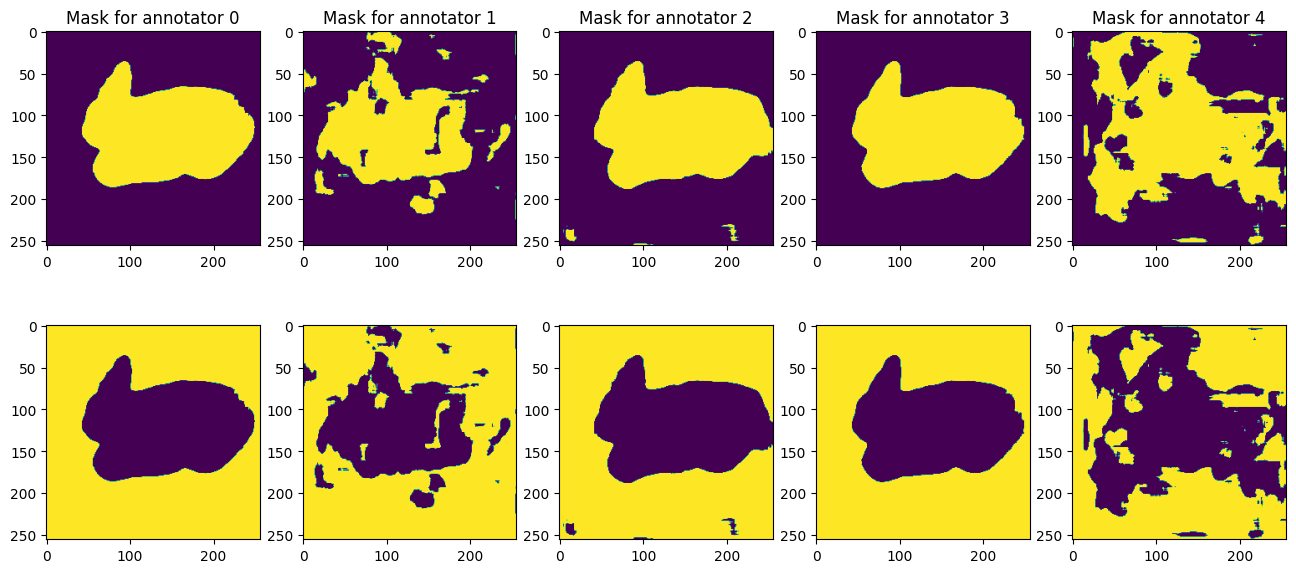

In [34]:
# Plotting the different perturbations to a sample and the resulting dimensions

for img,mask in train.take(1):
  print(f"Mask shape: {mask.shape} (batch_size * h * w * k * r) Img shape {img.shape}")
  fig, axes = plt.subplots(2,NUM_ANNOTATORS)
  fig.set_size_inches(16,7)
  for i in range(NUM_ANNOTATORS):
    axes[0][i].imshow((mask)[0,:,:,0,i])
    axes[0][i].set_title(f"Mask for annotator {i}")
    axes[1][i].imshow((mask)[0,:,:,-1,i])

## Loss for Tuned Gradual Class-wise Ensemble for Semi-supervised Learning

$$TGCE_{SS}(\mathbf{Y}_r,f(\mathbf X;\theta) | \left( \mathbf{\Lambda}_r (\mathbf X;\theta)) - \textbf{E}\left( {\left( \textbf{X} \circ {\textbf{K}}_{k \times k} \right)}_{w \times h} \right) \right) =\mathbb E_{r} \left\{ \mathbb E_{w,h} \left\{ \left( \Lambda_r (\mathbf X; \theta) - \textbf{E}\left( {\left( \textbf{X} \circ {\textbf{K}}_{k \times k} \right)}_{w \times h} \right)\right) \circ \mathbb E_k \bigg\{    \mathbf Y_r \circ \bigg( \frac{\mathbf 1 _{W\times H \times K} - f(\mathbf X;\theta) ^{\circ q }}{q} \bigg); k \in K  \bigg\}  + \\ \left(\mathbf 1 _{W \times H } - \left(\Lambda _r (\mathbf X;\theta)\right) - \textbf{E}\left( {\left( \textbf{X} \circ {\textbf{K}}_{k \times k} \right)}_{w \times h} \right)\right) \circ \bigg(   \frac{\mathbf 1_{W\times H} - (\frac {1}{k} \mathbf 1_{W\times H})^{\circ q}}{q} \bigg); w \in W, h \in H \right\};r\in R\right\} $$

In [35]:
# Custom loss function: TGCE SS

class TGCE_SS(Loss):
    """Tuned Gradual Class-wise Ensemble for Semi-supervised Learning Loss.

    This loss function implements the Tuned Gradual Class-wise Ensemble (TGCE) loss for 
    semi-supervised learning tasks. It is designed to improve the robustness of models 
    against noisy annotations by considering the reliability of annotators. The loss function 
    penalizes the disagreement between the model predictions and the ground truth labels, 
    taking into account the reliability of annotators.
    
    Methods
    ----------
    call(y_true, y_pred)
    get_config()

    """

    def __init__(self, q=0.1, name='TGCE_SS', R=NUM_ANNOTATORS, K_=2, smooth=1e-5, **kwargs):
        """Initializes the TGCE_SS loss object.

        Parameters:
            q (float): The tuning parameter for controlling the smoothness of the ensemble. 
                Defaults to 0.1.
            name (str): Name of the loss function. Defaults to 'TGCE_SS'.
            R (int): Number of annotators. Defaults to NUM_ANNOTATORS.
            K_ (int): Number of classes. Defaults to 2.
            smooth (float): Smoothing parameter to avoid division by zero. Defaults to 1e-5.
            **kwargs: Additional arguments passed to the parent class.
        
        """
        self.q = q
        self.R = R
        self.K_ = K_
        self.smooth = smooth
        super().__init__(name=name, **kwargs)

    def call(self, y_true, y_pred):
        """Computes the TGCE_SS loss.

        Parameters:
            y_true (tensor): Ground truth labels.
            y_pred (tensor): Predicted probabilities.

        Returns:
            A tuple containing the loss value, term_r, and term_c.

        """
        Lambda_r = y_pred[..., self.K_:]  # Annotators reliability -> extra cnn upsampling layer
        y_pred_ = y_pred[..., :self.K_]  # Segmented images from unet
        N, W, H, _ = y_pred_.shape
        y_pred_ = y_pred_[..., tf.newaxis]
        y_pred_ = tf.repeat(y_pred_, repeats=[self.R], axis=-1)  # Repeat f(x)

        epsilon = 1e-8  # Small constant to avoid divisions by zero
        y_pred_ = tf.clip_by_value(y_pred_, epsilon, 1.0 - epsilon)  # Limiting values between epsilon and 1 - epsilon

        term_r = tf.math.reduce_mean(tf.math.multiply(y_true, (tf.ones([N, W, H, self.K_, self.R]) - tf.pow(y_pred_, self.q)) / (self.q + epsilon + self.smooth)), axis=-2)
        term_c = tf.math.multiply(tf.ones([N, W, H, self.R]) - Lambda_r, (tf.ones([N, W, H, self.R]) - tf.pow((1 / self.K_ + self.smooth) * tf.ones([N, W, H, self.R]), self.q)) / (self.q + epsilon + self.smooth))

        # Avoid NaN in final loss function
        loss = tf.math.reduce_mean(tf.math.multiply(Lambda_r, term_r) + term_c)
        if tf.math.is_nan(loss):
            loss = tf.where(tf.math.is_nan(loss), tf.constant(0.0), loss)  # Replace NaN with 0.0
            print("Forced modification comes into action")
        return loss, term_r, term_c

    def get_config(self):
        """Gets the configuration of the loss function.

        Returns:
            A dictionary containing the configuration parameters of the loss function.

        """
        base_config = super().get_config()
        return {**base_config, "q": self.q}

## Definition of performance metrics

### DICE metric

$$\text{Dice} = {2 \cdot |\text{Intersection}| + \text{smooth} \over |\text{Union}| + \text{smooth}}$$

Where:

$|\text{Intersection}| = \sum_{i=1}^{N} y\_{true\_i} \cdot y\_{pred\_i}$, $|\text{Union}| = \sum_{i=1}^{N} y\_{true\_i} + \sum_{i=1}^{N} y\_{pred\_i}$


- $N$ is the total number of elements in the segmentation masks.
- $y\_{true\_i}$ and $y\_{pred\_i}$ represent the value of the i-th element in the ground truth and predicted segmentation masks, respectively.
- $\text{smooth}$ is a smoothing parameter to avoid division by zero.

In [36]:
# Definition of the DiceCoefficientMetric

def dice_metric(y_true, y_pred, axis=(1, 2), smooth=1e-5):
    """Computes the Dice coefficient metric for evaluating semantic segmentation.

    This function calculates the Dice coefficient metric, which measures the similarity 
    between ground truth and predicted segmentation masks.
    Parameters:
        y_true (tensor): Ground truth segmentation masks.
        y_pred (tensor): Predicted segmentation masks.
        axis (tuple of int): Axis along which to compute sums. Defaults to (1, 2).
        smooth (float): A smoothing parameter to avoid division by zero. Defaults to 1e-5.

    Returns:
        A scalar value representing the average Dice coefficient metric.

    """
    intersection = tf.reduce_sum(y_true * y_pred, axis=axis)
    union = tf.reduce_sum(y_true, axis=axis) + tf.reduce_sum(y_pred, axis=axis)
    dice = (2. * intersection + smooth) / (union + smooth)
    return tf.reduce_mean(dice)

### Jaccard metric

$$\text{Jaccard} = {|\text{Intersection}| + \text{smooth} \over |\text{Union}| + \text{smooth}}$$

Where:

$|\text{Intersection}| = \sum_{i=1}^{N} y\_{true\_i} \cdot y\_{pred\_i}$, $|\text{Union}| = \sum_{i=1}^{N} y\_{true\_i} + \sum_{i=1}^{N} y\_{pred\_i} - |\text{Intersection}|$
- $N$ is the total number of elements in the segmentation masks.
- $y\_{true\_i}$ and $y\_{pred\_i}$ represent the value of the i-th element in the ground truth and predicted segmentation masks, respectively.
- $\text{smooth}$ is a small smoothing parameter to avoid division by zero.

In [37]:
# Definition of the JaccardMetric

def jaccard_metric(y_true, y_pred, axis=(1, 2), smooth=1e-5):
    """Computes the Jaccard similarity coefficient as a metric for semantic segmentation.

    The Jaccard similarity coefficient, also known as the Intersection over Union (IoU),
    measures the similarity between two sets by comparing their intersection to their union.
    In the context of semantic segmentation, it quantifies the overlap between the ground
    truth segmentation masks and the predicted segmentation masks.

    Parameters:
        y_true (tensor): Ground truth segmentation masks.
        y_pred (tensor): Predicted segmentation masks.
        axis (tuple of int): Axes along which to compute sums. Defaults to (1, 2).
        smooth (float): A small smoothing parameter to avoid division by zero. Defaults to 1e-5.

    Returns:
        A tensor representing the mean Jaccard similarity coefficient.

    """
    intersection = tf.reduce_sum(y_true * y_pred, axis=axis)
    union = tf.reduce_sum(y_true, axis=axis) + tf.reduce_sum(y_pred, axis=axis) - intersection
    jaccard = (intersection + smooth) / (union + smooth)
    return tf.reduce_mean(jaccard)

### Sensitivity metric

$$\text{Sensitivity} = {\text{True Positives} \over \text{Actual Positives} + \text{smooth}}$$

Where:

$\text{True Positives} = \sum_{i=1}^{N} y\_{true\_i} \cdot y\_{pred\_i}$, $\text{Actual Positives} = \sum_{i=1}^{N} y\_{true\_i}$


- $N$ is the total number of elements in the labels.
- $y\_{true\_i}$ and $y\_{pred\_i}$ represent the value of the i-th element in the ground truth and predicted labels, respectively.
- $\text{smooth}$ is a small value added to the denominator to avoid division by zero.

In [38]:
# Definition of the SensitivityMetric

def sensitivity_metric(y_true, y_pred, axis=(1, 2), smooth=1e-5):
    """Computes the sensitivity as a metric for semantic segmentation.

    Sensitivity, also known as true positive rate or recall, measures the proportion 
    of actual positives that are correctly identified by the model. It is computed 
    as the ratio of true positives to the sum of true positives and false negatives.

    Parameters:
        y_true (tensor): Ground truth labels.
        y_pred (tensor): Predicted probabilities or labels.
        axis (tuple): Axes over which to perform the reduction. Defaults to (1, 2).
        smooth (float): A small value added to the denominator to avoid division by zero. 
            Defaults to 1e-5.

    Returns:
        The sensitivity metric averaged over the specified axes.

    """
    true_positives = tf.reduce_sum(y_true * y_pred, axis=axis)
    actual_positives = tf.reduce_sum(y_true, axis=axis)
    sensitivity = true_positives / (actual_positives + smooth)
    return tf.reduce_mean(sensitivity)

### Specificity metric

$$\text{Specificity} = {\text{True Negatives} \over \text{Actual Negatives} + \text{smooth}}$$

Where:

$\text{True Negatives} = \sum_{i=1}^{N} (1 - y\_{true\_i}) \cdot (1 - y\_{pred\_i})$, $\text{Actual Negatives} = \sum_{i=1}^{N} (1 - y\_{true\_i})$

- $N$ is the total number of samples.
- $y\_{true\_i}$ and $y\_{pred\_i}$ represent the ground truth label and predicted probability (or binary prediction) for the i-th sample, respectively.
- $\text{smooth}$ is a smoothing term to avoid division by zero.

In [39]:
# Definition of the SpecificityMetric

def specificity_metric(y_true, y_pred, axis=(1, 2), smooth=1e-5):
    """Computes the specificity as a metric for semantic segmentation.

    Specificity measures the proportion of actual negative cases that were correctly 
    identified as such. It is complementary to sensitivity (recall).

    Parameters:
        y_true (tensor): Ground truth binary labels.
        y_pred (tensor): Predicted probabilities or binary predictions.
        axis (tuple): Axes over which to perform reduction. Defaults to (1, 2).
        smooth (float): Smoothing term to avoid division by zero. Defaults to 1e-5.

    Returns:
        A tensor representing the specificity metric.

    """
    true_negatives = tf.reduce_sum((1 - y_true) * (1 - y_pred), axis=axis)
    actual_negatives = tf.reduce_sum(1 - y_true, axis=axis)
    specificity = true_negatives / (actual_negatives + smooth)
    return tf.reduce_mean(specificity)

## Layers definition

In [47]:
# Definition of layers for the neural network structure 

DefaultConv2D = partial(layers.Conv2D,
                        kernel_size=3, activation='relu', padding="same")

DilatedConv = partial(layers.Conv2D,
                        kernel_size=3, activation='relu', padding="same", dilation_rate=10, name="DilatedConv")

DefaultPooling = partial(layers.MaxPool2D,
                        pool_size=2)

upsample = partial(layers.UpSampling2D, (2,2))

## Kernel initializers

In [41]:
def kernel_initializer(seed):
    """Returns a Glorot uniform initializer for kernel weights.

    Glorot uniform initializer, also known as Xavier uniform initializer, 
    is commonly used to initialize the weights of kernels in neural network layers. 
    It draws samples from a uniform distribution within a certain range, 
    calculated to keep the variance of the weights constant across layers. 
    This initializer is useful for training deep neural networks.

    Parameters:
        seed (int): Random seed for reproducibility.

    Returns:
        A Glorot uniform initializer for kernel weights.

    """
    return tf.keras.initializers.GlorotUniform(seed=seed)

## Activation functions

### SparseSoftmax

$$\text{SparseSoftmax}(x) = \frac{\exp(x - \text{max}(x))}{\text{sum}(\exp(x - \text{max}(x)))}$$

Where:

- $x$ is the input tensor.
- $\text{max}(x)$ is the maximum value in the tensor $x$.
- $\text{sum}$ is the sum of the exponential values of $x - \text{max}(x)$.

In [42]:
class SparseSoftmax(tf.keras.layers.Layer):
    """Custom layer implementing the sparse softmax activation function.

    This layer computes the softmax activation function for a given input tensor,
    handling sparse input efficiently.
    
    Methods
    ----------
    build(input_shape)
    call(x)
    compute_output_shape(input_shape)

    """

    def __init__(self, **kwargs):
        """Initializes the SparseSoftmax layer.

        Parameters:
            **kwargs: Additional arguments to be passed to the parent class.

        """
        super(SparseSoftmax, self).__init__(**kwargs)

    def build(self, input_shape):
        """Builds the layer.

        Parameters:
            input_shape (tuple): Shape of the input tensor.

        """
        super(SparseSoftmax, self).build(input_shape)

    def call(self, x):
        """Computes the output of the layer.

        Parameters:
            x (tensor): Input tensor.

        Returns:
            A tensor representing the output of the softmax activation function.

        """
        e_x = K.exp(x - K.max(x, axis=-1, keepdims=True))
        sum_e_x = K.sum(e_x, axis=-1, keepdims=True)
        output = e_x / (sum_e_x + K.epsilon())
        return output

    def compute_output_shape(self, input_shape):
        """Computes the output shape of the layer.

        Parameters:
            input_shape (tuple): Shape of the input tensor.

        Returns:
            The same shape as the input tensor.

        """
        return input_shape

### Softmax bounded

$$\text{SoftmaxBounded}(x) = \text{softmax}(x) \cdot (\text{sup_limit} - \text{inf_limit}) + \text{inf_limit}$$

Where:

- $x$ is the input tensor.
- $\text{softmax}(x)$ denotes the standard softmax activation function applied to the input tensor $x$.
- $\text{sup_limit}$ is the upper limit of the output range.
- $\text{inf_limit}$ is the lower limit of the output range.

In [43]:
class SoftmaxCustom(Layer):
    """Custom layer that applies a modified softmax activation.

    This layer applies a softmax activation to the input tensor and scales the output
    values to lie within a specified range. It is particularly useful when you need
    to ensure that the output values of the softmax are within certain bounds.
    
    Methods
    ----------
    build(input_shape)
    call(x)
    compute_output_shape(input_shape)

    """

    def __init__(self, sup_limit, inf_limit, **kwargs):
        """Initializes the SoftmaxCustom layer.

        Parameters:
            sup_limit (float): The upper limit of the output range.
            inf_limit (float): The lower limit of the output range.
            **kwargs: Additional arguments passed to the parent class.

        """
        super(SoftmaxCustom, self).__init__(**kwargs)
        self.sup_limit = sup_limit
        self.inf_limit = inf_limit

    def build(self, input_shape):
        """Builds the SoftmaxCustom layer.

        Parameters:
            input_shape (tuple): Shape of the input tensor.

        """
        super(SoftmaxCustom, self).build(input_shape)

    def call(self, x):
        """Applies the modified softmax activation.

        Parameters:
            x (tensor): Input tensor.

        Returns:
            A tensor representing the output of the modified softmax activation.

        """
        return K.softmax(x) * (self.sup_limit - self.inf_limit) + self.inf_limit

    def compute_output_shape(self, input_shape):
        """Computes the output shape of the SoftmaxCustom layer.

        Parameters:
            input_shape (tuple): Shape of the input tensor.

        Returns:
            The same shape as the input tensor.

        """
        return input_shape

## Assembling UNet with Loss TGCE and metrics

![Unet-TGCELoss](https://lh3.googleusercontent.com/fife/ALs6j_FQpKDYXh1PSuK4B7zca2t-aLNDOGiHv3Cx4wnqrj5tDZp7LFygbkh3Pw0t3sIu7Fly0fC7BrL5I8HME3fXUAFPgKIkzPuTL8W1m6kBgaqQf8yMOt89R7PUO4PNgy0dG5DbixazOdTRquMcEzJ1WiYWf33c1gIK9_8eJhDmmhAYutY-HkMQBerxetLXEdSc2euRjPf7yKb44U9MwhfhX7UWt4Scndk6Pn6FQIczftrSXrAkpm1wQ3KqEuvtfRyffpoYAc48uZ2SYu9G22X9ZIyWBiGhQbuOe1MpW27lJ8SAtXcG5BIt6jy55NTFSWeh0AhuVM-3gwKhTOYqwy4C0lcbXQJ8XobTaWAQWxSyCPHkGfsccxwkILRi9-13j7Bd22ZReapWyu7w0Yrn4I2qxpvJ7kiVjElZWw8foKitEHsELCqLOKcJXrGQGr0qo9maTPzU_aLVYObrDrvndmdOSfkThd2hYswinp75TaoDSMOa3XJIK-02Rv9uS3S8w6VaWX3kggtxDeGlUyfLs8zBOj9SI0sZ8X8l0fd3nFUgOb1lTf29Eod57vzVICMMQvWO0sgabPavO7QxiMt5EvcJHrdZz0U1OYtC91SAszpd58JQSKPChrRaYjIiPNZPWdkFkztzFhClTMlgw8U6SUTSWHYJEDXFeb15Dnv4kNENTV0zpBT6PCdrdpqsNMnhGPGpaCeVPivt85Em8mz1I5YApYKKstjP-L5GG3cCSM3KSe2lu13cVZoBHDXAVUfmqlGgj37MGYsAi5V8U-S4G7Xtun40AYqxRC4OhptA2AdShQ6JOdPfKAlmhLy4rH9Ae1Euu3KrCcYuFY_-_x0POr45C7ouP5uyOAgtWDvM75yyAYkSBVqMYKV-VFnLW_piSQNsZiQXwqjiCGYTi4eYJVsn8TatuJW7o6L1MlO5qdtdgrWNN4lNTl1_CFB8b55wrzZgCxjuuUUGRKU1hA8cEtECtktWbUhfrwvgdCU7-fvuUMIZF7OBizlzGXQ-tYYbQjGpUzfSq19efU_9Wqj8Fep5fNRKuLRTLVP4d-GLy7ecoHbYR-bDx-Ln3oTiiEJ7n1_H6vrRskybpNN_eGhokwxNy3_9h2jWeEAxwWJn6tMf19lkpwdsYanf-VTp5SthSoWb7BA7_qGGXScorMXbbFlKGjAfYKLuXLapcO2wy1yvQe87fggoTkyECfNg_3ie_TdEZlmhdvjAX0oNNOFH6KOsck3WbRdB3cOyICd872hkS0QNB8TxdPVRAR_2ifRxBKOygqBYA0WKEVl2VPCnDDfmwJp401ORkk6AFEZssaKzWinP9Kt3Xo436vo_983b8oNLowlhfeJpHR9iWl9iaHxwU_LShYvCrG8L_eLeaPFAVVXgpPF31KGgeKOSFoaEDvO5OpMrPJ0HrDZPZSXw6KMNtf0B0t_1R6OJoD9OpJSAvUVrVd9xxnsVJxZGSGFr28MNrSJ1gl9PRPyLalFiakDhxYO2PwshZJrzf-GaUANkRx-lJpnzPkqlqcMxl1HNDYSnY73A3sb3kLJe7m_eq0EfCpJkTK4oNPF6-fS1YcQguS8BKnlMXdWfTTywv6Cjhb7ROe1qB83tCtU7syhVEuTzMohgcm-5jT-AOtGJX-WGQny3mboNKZU0j_y9sHAJD7UmTihwutj4Hr8eF1yFUbOTdw=w1632-h928)

In [48]:
def unet_tgce(input_shape=(128,128,3), name='UNET', out_channels=2, out_ActFunction = SparseSoftmax(), n_scorers = 5, out_ActFunction_Lambda = SparseSoftmax()):#SoftmaxCustom(sup_limit=0.9, inf_limit=0.1)):
  
  """Creates a U-Net model.
  
  This function constructs a U-Net model for semantic segmentation tasks. 
  The U-Net architecture consists of an encoder-decoder structure with skip 
  connections between corresponding layers of the encoder and decoder.
  
  Parameters:
        input_shape (tuple): The shape of the input image data. Defaults to (128, 128, 3).
        name (str): Name of the model. Defaults to 'UNET'.
        out_channels (int): Number of output channels. Defaults to 2.
        out_ActFunction (tf.keras.activations): Activation function for the output layer. 
            Defaults to SparseSoftmax().
        n_scorers (int): Number of scorers. Defaults to 5.
        out_ActFunction_Lambda (tf.keras.activations): Activation function for the 
            lambda output. Defaults to SparseSoftmax().

  Returns:
        A U-Net model.
  """
  
  # Encoder
  input = layers.Input(shape=input_shape)

  x =  layers.BatchNormalization(name='Batch00')(input)

  x = DefaultConv2D(8,kernel_initializer=kernel_initializer(34),name='Conv10')(x)
  x = layers.Dropout(0.1)(x)
  x = layers.BatchNormalization(name='Batch10')(x)
  x = level_1 = DefaultConv2D(8,kernel_initializer=kernel_initializer(4),name='Conv11')(x)
  x = layers.Dropout(0.1)(x)
  x = layers.BatchNormalization(name='Batch11')(x)
  x = DefaultPooling(name='Pool10')(x) # 128x128 -> 64x64

  x = DefaultConv2D(16,kernel_initializer=kernel_initializer(56),name='Conv20')(x)
  x = layers.Dropout(0.1)(x)
  x = layers.BatchNormalization(name='Batch20')(x)
  x = level_2 = DefaultConv2D(16,kernel_initializer=kernel_initializer(32),name='Conv21')(x)
  x = layers.Dropout(0.1)(x)
  x = layers.BatchNormalization(name='Batch22')(x)
  x = DefaultPooling(name='Pool20')(x) # 64x64 -> 32x32


  x = DefaultConv2D(32,kernel_initializer=kernel_initializer(87),name='Conv30')(x)
  x = layers.Dropout(0.1)(x)
  x = layers.BatchNormalization(name='Batch30')(x)
  x = level_3 = DefaultConv2D(32,kernel_initializer=kernel_initializer(30),name='Conv31')(x)
  x = layers.Dropout(0.1)(x)
  x = layers.BatchNormalization(name='Batch31')(x)
  x = DefaultPooling(name='Pool30')(x) # 32x32 -> 16x16

  x = DefaultConv2D(64,kernel_initializer=kernel_initializer(79),name='Conv40')(x)
  x = layers.Dropout(0.1)(x)
  x = layers.BatchNormalization(name='Batch40')(x)
  x = level_4 = DefaultConv2D(64,kernel_initializer=kernel_initializer(81),name='Conv41')(x)
  x = layers.Dropout(0.1)(x)
  x = layers.BatchNormalization(name='Batch41')(x)
  x = DefaultPooling(name='Pool40')(x) # 16x16 -> 8x8


  #Decoder
  x = DefaultConv2D(128,kernel_initializer=kernel_initializer(89),name='Conv50')(x)
  x = layers.Dropout(0.1)(x)
  x = layers.BatchNormalization(name='Batch50')(x)
  x = DefaultConv2D(128,kernel_initializer=kernel_initializer(42),name='Conv51')(x)
  x = layers.Dropout(0.1)(x)
  x = layers.BatchNormalization(name='Batch51')(x)


  x = upsample(name='Up60')(x) # 8x8 -> 16x16
  x = layers.Concatenate(name='Concat60')([level_4,x])
  x = DefaultConv2D(64,kernel_initializer=kernel_initializer(91),name='Conv60')(x)
  x = layers.Dropout(0.1)(x)
  x = layers.BatchNormalization(name='Batch60')(x)
  x = DefaultConv2D(64,kernel_initializer=kernel_initializer(47),name='Conv61')(x)
  x = layers.Dropout(0.1)(x)
  x = layers.BatchNormalization(name='Batch61')(x)

  x = upsample(name='Up70')(x) # 16x16 -> 32x32
  x = layers.Concatenate(name='Concat70')([level_3,x])
  x = DefaultConv2D(32,kernel_initializer=kernel_initializer(21),name='Conv70')(x)
  x = layers.Dropout(0.1)(x)
  x = layers.BatchNormalization(name='Batch70')(x)
  x = DefaultConv2D(32,kernel_initializer=kernel_initializer(96),name='Conv71')(x)
  x = layers.Dropout(0.1)(x)
  x = layers.BatchNormalization(name='Batch71')(x)

  x = upsample(name='Up80')(x) # 32x32 -> 64x64
  x = layers.Concatenate(name='Concat80')([level_2,x])
  x = DefaultConv2D(16,kernel_initializer=kernel_initializer(96),name='Conv80')(x)
  x = layers.Dropout(0.1)(x)
  x = layers.BatchNormalization(name='Batch80')(x)
  x = DefaultConv2D(16,kernel_initializer=kernel_initializer(98),name='Conv81')(x)
  x = layers.Dropout(0.1)(x)
  x = layers.BatchNormalization(name='Batch81')(x)

  x = upsample(name='Up90')(x) # 64x64 -> 128x128
  x = layers.Concatenate(name='Concat90')([level_1,x])
  x = DefaultConv2D(8,kernel_initializer=kernel_initializer(35),name='Conv90')(x)
  x = layers.Dropout(0.1)(x)
  x = layers.BatchNormalization(name='Batch90')(x)
  x = DefaultConv2D(8,kernel_initializer=kernel_initializer(7),name='Conv91')(x)
  x = layers.Dropout(0.1)(x)
  x = layers.BatchNormalization(name='Batch91')(x)

  xy = DefaultConv2D(out_channels,kernel_size=(1,1),activation=out_ActFunction,
                      kernel_initializer=kernel_initializer(42),
                      name='Conv100')(x)
  x_lambda = DilatedConv(n_scorers,kernel_size=(1,1),activation= out_ActFunction_Lambda,
                        kernel_initializer=kernel_initializer(42), 
                        name='DilatedConv101-Lambda')(x)
  y = layers.Concatenate(name='Concat100')([xy,x_lambda])

  model = Model(input,y,name=name)

  return model

In [49]:
# Compilation of the model with relevant adjustments

model = unet_tgce(
    input_shape = TARGET_SHAPE + (3,),
    out_channels= 2, 
    n_scorers= NUM_ANNOTATORS )#TARGET_SHAPE + (3,)
model.compile(
    loss=TGCE_SS(q=0.1,R=NUM_ANNOTATORS,K_=2),
    metrics = [dice_metric, jaccard_metric, sensitivity_metric, specificity_metric],
    optimizer=tf.keras.optimizers.Adam(),)
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 Batch00 (BatchNormalizatio  (None, 256, 256, 3)          12        ['input_2[0][0]']             
 n)                                                                                               
                                                                                                  
 Conv10 (Conv2D)             (None, 256, 256, 8)          224       ['Batch00[0][0]']             
                                                                                                  
 dropout_18 (Dropout)        (None, 256, 256, 8)          0         ['Conv10[0][0]']           

## Loading of the different parts of the dataset

In [16]:
# Loading of the training part of the database in a tensor manner

X_train = []
y_train = []

for img, mask in train.take(21):
    img_1 = img
    mask_1 = mask
    X_train.append(img_1)
    y_train.append(mask_1)

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


In [17]:
# Loading of the validation part of the database in a tensor manner

X_val = []
y_val = []

for img, mask in val.take(5):
    img_1 = img
    mask_1 = mask
    X_val.append(img_1)
    y_val.append(mask_1)

In [18]:
# Loading of the testing part of the database in a tensor manner

X_test = []
y_test = []

for img, mask in test.take(5):
    img_1 = img
    mask_1 = mask
    X_test.append(img_1)
    y_test.append(mask_1)

## Plotting function of the generated masks and the performance of the annotators

In [19]:
# Plot function to show the segmentation performance of the network and each annotator

def plotter_fn(predictions, x_batch, num_img_batch, num_img_pred):
    """Plots the original image and segmented images.

    This function creates a visualization of the original image and its corresponding
    segmented images generated by a segmentation model. It displays the original image
    and segmented images for each channel in a subplot grid.

    Parameters:
        predictions (tensor): Predicted segmentation masks generated by the model.
        x_batch (tensor): Batch of input images.
        num_img_batch (int): Index of the image within the input batch to be visualized.
        num_img_pred (int): Index of the image within the predicted masks to be visualized.

    Returns:
        None

    """
    # Create figure and subplots
    if predictions.shape[-1] >= 3:
        fig, axes = plt.subplots(2, predictions.shape[-1] - 2, figsize=(15, 6))
        for i in range(3, predictions.shape[-1] - 2):
            axes[0, i].axis('off')
    else:
        fig, axes = plt.subplots(2, 3, figsize=(15, 6))
    
    # First row of images
    axes[0, 0].imshow(x_batch[num_img_batch,:,:,:])
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    channel_1 = predictions[num_img_pred, :, :, 0]
    channel_1 = tf.where(channel_1 < 0.5, 0.0, 1.0)
    axes[0, 1].imshow(tf.math.log(channel_1))
    axes[0, 1].set_title('Segmented image - Channel 1')
    axes[0, 1].axis('off')

    channel_2 = predictions[num_img_pred, :, :, 1]
    channel_2 = tf.where(channel_2 < 0.5, 0.0, 1.0)                 
    axes[0, 2].imshow(tf.math.log(channel_2))
    axes[0, 2].set_title('Segmented image - Channel 2')
    axes[0, 2].axis('off')
    
    # Second row of images
    
    # Define visualization range from 0 to 1
    vmin = 0.0
    vmax = 1.0
    tensors_list = []
    
    for i in range(0, predictions.shape[-1] - 2):
        axes[1, i].imshow(predictions[num_img_pred, :, :, i+2], vmin=vmin, vmax=vmax)
        tensors_list.append(predictions[num_img_pred, :, :, i+2])
        axes[1, i].set_title(f'Annotator - {i+1} $\lambda$: {np.mean(predictions[num_img_pred, :, :, i+2]):.3f}')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()
        
    sum_tensors = tf.reduce_sum(tensors_list, axis=0)  # Sum along axis 0
    print(sum_tensors)

## Regularization Lasso and Ridge

$$\text{RegularizationLoss}(\text{model}, \lambda_1, \lambda_2) = \text{L1Loss}(\text{model}, \lambda_1) + \text{L2Loss}(\text{model}, \lambda_2)$$

Where:

- $\text{model}$ represents the neural network model.
- $\lambda_1$ is the coefficient for L1 regularization.
- $\lambda_2$ is the coefficient for L2 regularization.
- $\text{L1Loss}(\text{model}, \lambda_1)$ calculates the L1 regularization loss, which is the sum of the absolute values of the trainable weights multiplied by $\lambda_1$.
- $\text{L2Loss}(\text{model}, \lambda_2)$ calculates the L2 regularization loss, which is the sum of the squared values of the trainable weights multiplied by $\lambda_2$.

In [20]:
def compute_regularization_loss(model, lambda1: float, lambda2: float) -> float:
    """Computes the regularization loss for a given model.

    This function calculates the combined L1 and L2 regularization loss for the trainable
    parameters of a neural network model.

    Parameters:
        model (tf.keras.Model): The neural network model.
        lambda1 (float): Coefficient for L1 regularization.
        lambda2 (float): Coefficient for L2 regularization.

    Returns:
        float: The combined regularization loss.

    """
    l1_loss = tf.add_n([tf.reduce_sum(tf.abs(w)) for w in model.trainable_weights if 'bias' not in w.name]) * lambda1
    l2_loss = tf.add_n([tf.reduce_sum(tf.square(w)) for w in model.trainable_weights if 'bias' not in w.name]) * lambda2
    return l1_loss + l2_loss

## Training section

Epoch 1/12
Training time: 34.932s
Loss: 0.608, Dice: 0.537, Jaccard: 0.376, Specificity: 0.564, Sensitivity: 0.564
Val_Loss: 0.602, Val_Dice: 0.484, Val_Jaccard: 0.326, Val_Specificity: 0.500, Val_Sensitivity: 0.500
Epoch 2/12
Training time: 24.835s
Loss: 0.589, Dice: 0.622, Jaccard: 0.461, Specificity: 0.656, Sensitivity: 0.656
Val_Loss: 0.600, Val_Dice: 0.505, Val_Jaccard: 0.343, Val_Specificity: 0.535, Val_Sensitivity: 0.535
Epoch 3/12
Training time: 24.675s
Loss: 0.582, Dice: 0.681, Jaccard: 0.527, Specificity: 0.716, Sensitivity: 0.716
Val_Loss: 0.599, Val_Dice: 0.511, Val_Jaccard: 0.352, Val_Specificity: 0.526, Val_Sensitivity: 0.526
Epoch 4/12
Training time: 24.558s
Loss: 0.578, Dice: 0.702, Jaccard: 0.552, Specificity: 0.735, Sensitivity: 0.735
Val_Loss: 0.599, Val_Dice: 0.510, Val_Jaccard: 0.356, Val_Specificity: 0.525, Val_Sensitivity: 0.525
Epoch 5/12
Training time: 24.991s
Loss: 0.575, Dice: 0.722, Jaccard: 0.576, Specificity: 0.753, Sensitivity: 0.753
Val_Loss: 0.612, Val_

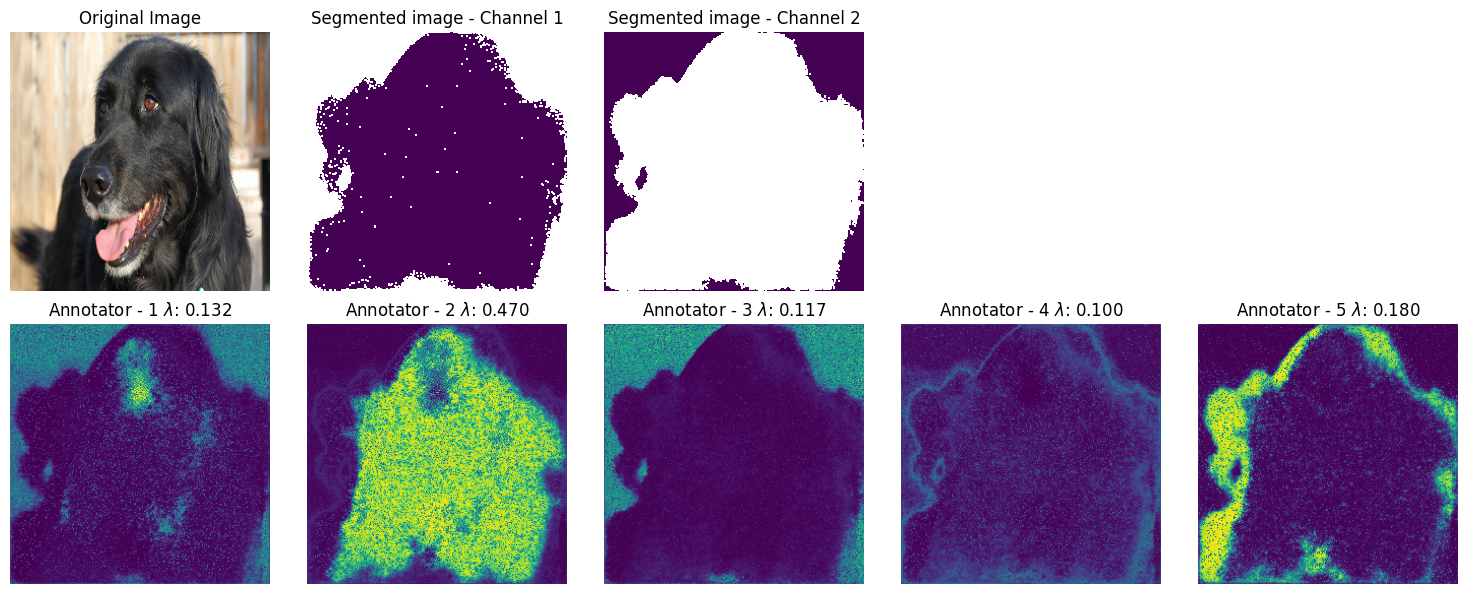

tf.Tensor(
[[0.99999994 1.         1.         ... 1.         1.0000001  1.        ]
 [0.9999999  1.         0.99999994 ... 0.99999994 0.99999994 1.        ]
 [0.99999994 1.         0.9999999  ... 0.99999994 0.99999994 0.99999994]
 ...
 [0.99999994 1.0000001  0.99999994 ... 1.         1.         0.99999994]
 [0.99999994 1.         1.         ... 1.0000001  1.         1.0000001 ]
 [1.         1.         1.0000001  ... 0.9999999  1.0000001  0.99999994]], shape=(256, 256), dtype=float32)
Learning Rate in epoch 10: 0.0010000000474974513
Epoch 11/12
Training time: 25.232s
Loss: 0.566, Dice: 0.779, Jaccard: 0.650, Specificity: 0.806, Sensitivity: 0.806
Val_Loss: 0.591, Val_Dice: 0.665, Val_Jaccard: 0.523, Val_Specificity: 0.692, Val_Sensitivity: 0.692
Epoch 12/12
Training time: 24.479s
Loss: 0.565, Dice: 0.785, Jaccard: 0.659, Specificity: 0.811, Sensitivity: 0.811
Val_Loss: 0.590, Val_Dice: 0.689, Val_Jaccard: 0.551, Val_Specificity: 0.708, Val_Sensitivity: 0.708


In [24]:
# Custom training function applying gradient descent

# Set random seed for numpy
np.random.seed(42)

# Set random seed for Tensorflow
tf.keras.backend.clear_session()
tf.random.set_seed(42)

batch_size = 32 # Define the batch size
optimizer = tf.keras.optimizers.Adam()#(learning_rate=0.001) # Define the optimizer
model_name = "UNET-TGCE_SS" # Define the model name for WanDB
loss_fn = TGCE_SS(q=0.1,R=NUM_ANNOTATORS,K_=2)# Define the loss function

num_epochs = 150 # Number of epochs
lambda1, lambda2 = 0, 0 #1e-3,1e-3

lenght_batch_train = len(X_train)
lenght_batch_val = len(X_val)

wandb.login(key="YourWanDBAPIKey")
run = wandb.init(config=None, project='YourNameProject', entity='YourEntity')
wandb.config.dataset_name = "OxfordPets"
wandb.config.architecture_name = "UNet"

# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    start_time = time.time()
    
    epoch_train_loss = 0.0  # Initialize accumulated loss for this epoch
    
    # Reset the state of the metric at the beginning of each epoch
    dice_metric_train = np.zeros(lenght_batch_train)
    jaccard_metric_train = np.zeros(lenght_batch_train)
    specificity_metric_train = np.zeros(lenght_batch_train)
    sensitivity_metric_train = np.zeros(lenght_batch_train)
    
    for batch in range(lenght_batch_train):
        
      x_batch = np.array(X_train[batch])
      y_batch = np.array(y_train[batch])
      y_batch[y_batch < 0.5] = 0 # Thresholding
      y_batch[y_batch >= 0.5] = 1
        
      with tf.GradientTape() as tape:
          # Make prediction
          predictions = model(x_batch, training=True)
          # Calculate the loss with L1 and L2 regularitazion
          loss, term_r, term_c = loss_fn.call(y_batch, predictions)
          reg_loss = compute_regularization_loss(model, lambda1, lambda2)
          total_loss = loss + reg_loss

      # Calculate the gradient of the loss with respect to the model's parameters
      gradients = tape.gradient(total_loss, model.trainable_variables)

      # Update model weights using the optimizer
      optimizer.apply_gradients(zip(gradients, model.trainable_variables))

      # Accumulate the loss of this batch
      epoch_train_loss += total_loss.numpy()  # Convert loss tensor to numeric value
      # epoch_dice += dice.numpy()

      array_ybatch = y_batch[..., :2]
      array_ybatch = array_ybatch[...,0] 

      # Convert tensor to a NumPy array
      array_predictions = predictions.numpy()

      # Select the first two channels of the array
      array_predictions = array_predictions[..., :2]

      # Calculate metrics and update its state
      dice_metric_train[batch] = dice_metric(array_ybatch, array_predictions)
      jaccard_metric_train[batch] = jaccard_metric(array_ybatch, array_predictions)
      specificity_metric_train[batch] = specificity_metric(array_ybatch, array_predictions)
      sensitivity_metric_train[batch] = sensitivity_metric(array_ybatch, array_predictions)
            
    # Get the Loss Mean 
    epoch_train_loss /= lenght_batch_train 
    
    # Get the Dice metric value at the end of each epoch
    epoch_train_dice = np.mean(dice_metric_train)
    epoch_train_jaccard = np.mean(jaccard_metric_train)
    epoch_train_specificity = np.mean(specificity_metric_train)
    epoch_train_sensitivity = np.mean(sensitivity_metric_train)
    
############################################################################################

    # PERFORMANCE ON VALIDATION DATA
    
    
    epoch_val_loss = 0.0 # Initialize accumulated loss for this epoch
    
    # Reset the state of the metric for each epoch
    dice_metric_val = np.zeros(lenght_batch_val)
    jaccard_metric_val = np.zeros(lenght_batch_val)
    specificity_metric_val = np.zeros(lenght_batch_val)
    sensitivity_metric_val = np.zeros(lenght_batch_val)
    
    for batch in range(lenght_batch_val):
        
      x_batch_val = np.array(X_val[batch])
      y_batch_val = np.array(y_val[batch])
      y_batch_val[y_batch_val < 0.5] = 0 # Thresholding
      y_batch_val[y_batch_val >= 0.5] = 1
      
      with tf.GradientTape() as tape:
          # Make prediction
          val_predictions = model(x_batch_val, training=False)
          # Calculate the loss with L1 and L2 regularitazion
          val_loss, _, _ = loss_fn.call(y_batch_val, val_predictions)
          val_total_loss = val_loss + reg_loss
      
      # Accumulate the loss of this batch
      epoch_val_loss += val_total_loss.numpy()  # Convert loss tensor to numeric value

      array_ybatch_val = y_batch_val[..., :2]
      array_ybatch_val = array_ybatch_val[...,0] 

      # Convert tensor to a NumPy array
      array_predictions_val = val_predictions.numpy()

      # Select the first two channels of the array
      array_predictions_val = array_predictions_val[..., :2]

      # Calculate metrics and update its state
      dice_metric_val[batch] = dice_metric(array_ybatch_val, array_predictions_val)
      jaccard_metric_val[batch] = jaccard_metric(array_ybatch_val, array_predictions_val)
      specificity_metric_val[batch] = specificity_metric(array_ybatch_val, array_predictions_val)
      sensitivity_metric_val[batch] = sensitivity_metric(array_ybatch_val, array_predictions_val)
            
    # Get the Loss Mean 
    epoch_val_loss /= lenght_batch_val 
    
    # Get the Dice metric value at the end of each epoch
    epoch_val_dice = np.mean(dice_metric_val)
    epoch_val_jaccard = np.mean(jaccard_metric_val)
    epoch_val_specificity = np.mean(specificity_metric_val)
    epoch_val_sensitivity = np.mean(sensitivity_metric_val)  
    
############################################################################################
    
    # Get epoch training time
    end_time = time.time()
    execution_time = end_time - start_time
    # Print the execution time, loss value, and Dice value for each epoch
    print(f"Training time: {execution_time:.3f}s")
    print(f"Loss: {epoch_train_loss:.3f}, Dice: {epoch_train_dice:.3f}, Jaccard: {epoch_train_jaccard:.3f}, Specificity: {epoch_train_specificity:.3f}, Sensitivity: {epoch_train_sensitivity:.3f}")
    print(f"Val_Loss: {epoch_val_loss:.3f}, Val_Dice: {epoch_val_dice:.3f}, Val_Jaccard: {epoch_val_jaccard:.3f}, Val_Specificity: {epoch_val_specificity:.3f}, Val_Sensitivity: {epoch_val_sensitivity:.3f}")
    wandb.log({'Epoch':epoch, 'Loss':epoch_train_loss, 'Dice':epoch_train_dice, 'Jaccard':epoch_train_jaccard, 'Specificity':epoch_train_specificity, 'Sensitivity':epoch_train_sensitivity,  
            'val_Loss':epoch_val_loss, 'val_Dice':epoch_val_dice, 'val_Jaccard':epoch_val_jaccard, 'val_Specificity':epoch_val_specificity, 'val_Sensitivity':epoch_val_sensitivity})
    if (epoch + 1) % 10 == 0:
        num_img_batch = num_img_pred = random.randint(0, batch_size - 1)
        plotter_fn(predictions,x_batch,num_img_batch, num_img_pred)  # Plot predictions
        current_lr = optimizer.learning_rate.numpy()  # Get current learning rate
        print(f"Learning Rate in epoch {epoch+1}: {current_lr}")
    if tf.math.is_nan(loss):
        print("====================================================================\n",term_r,"====================================================================\n",term_r,"====================================================================\n")

model.save(f'{model.name}.h5')
model.save(f'{model.name}.keras')
wandb.save(f'{model.name}.h5')
wandb.save(f'{model.name}.keras')
run.finish()

## Predictions of model UNet - TGCE Loss and model UNet baseline on test data

In [31]:
# Model UNet baseline prediction for a sample
prediction = model_ann.predict(X_test_1[1:2,:,:,:])

1/1 [==============================] - 0s 20ms/step


(-0.5, 255.5, 255.5, -0.5)

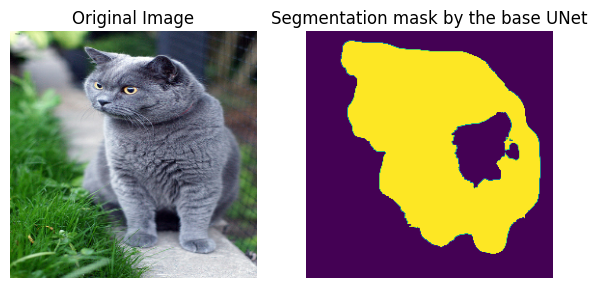

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4))

axes[0].imshow(X_test_1[1])
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(prediction[0])
axes[1].set_title('Segmentation mask by the UNet baseline')
axes[1].axis('off')


In [30]:
# Model UNet- TGCE Loss prediction for a sample

X_test_1 = X_test[0]
prediction = model.predict(X_test_1[1:2,:,:,:])

1/1 [==============================] - 0s 21ms/step


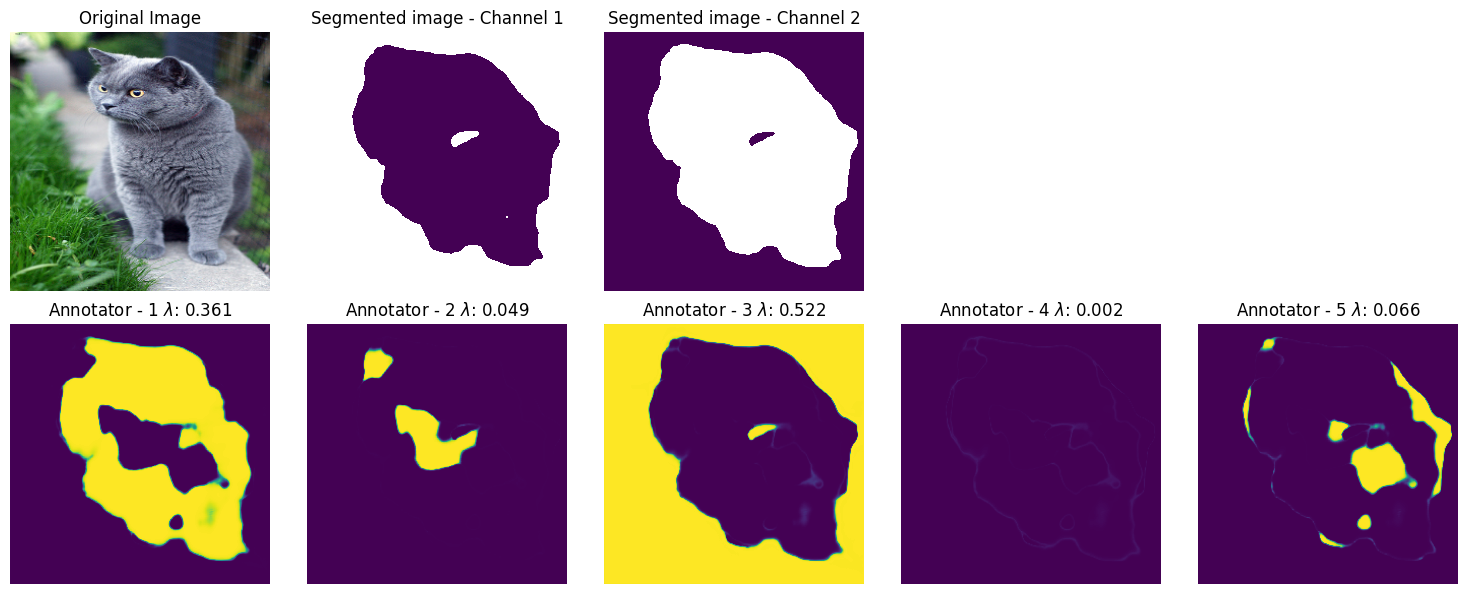

tf.Tensor(
[[0.9999999  0.99999994 0.9999998  ... 1.         1.         0.99999994]
 [0.99999994 1.         0.9999999  ... 0.9999998  0.9999998  0.9999999 ]
 [0.9999999  0.99999994 0.99999976 ... 0.99999994 0.9999998  0.9999999 ]
 ...
 [0.9999998  0.99999994 0.99999994 ... 0.9999998  1.         1.        ]
 [0.9999999  0.9999998  0.9999999  ... 1.         0.9999999  0.9999999 ]
 [0.9999999  1.         0.9999998  ... 0.99999994 1.         0.9999998 ]], shape=(256, 256), dtype=float32)


In [31]:
plotter_fn(prediction,X_test_1,1,0)